In [1]:
import sys
sys.path.append(sys.path[0].split('NewEP3Exp')[0] + 'NewEP3Exp/Code')
sys.path.append(sys.path[0].split('NewEP3Exp')[0] + 'NewEP3Exp/Code/Instruments/SpectrumInstruments')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# import SpectrumAWG as SI
import time
from numba import jit


In [2]:
SR = 625e6 # max samling rate
l = 200e-3*SR # a "long" ringdown might take 200 ms
samps = np.arange(int(l))
tstamps = samps/SR # We'd probably want to pass around timestamps instead of sample number since that'll be something we compute a lot

# lets try to do this with some actually realistic parameters

f0 = 83e6 # frequency corresponding to Delta = 0

fm1 = 2.423806731707168*1e6 # Hz
fm2 = 3.330978169785124*1e6 # Hz

eta = -50 # Hz
delta_1 = -0.5e6 # Hz
delta_2 = -0.735e6 # Hz
delta_blue = 3.5e6 # Hz

F1_1 = f0 - fm1 + eta/2 + delta_1
F2_1 = f0 - fm2 - eta/2 + delta_1
F3 = f0 + delta_blue


F1_2 = f0 - fm1 + eta/2 + delta_2
F2_2 = f0 - fm2 - eta/2 + delta_2

A1_1 = .23452
A2_1 = .52341
A3 = .315673

A1_2 = .12367
A2_2 = .35256


def func1(samp, SR, f1, f2, a1, a2):
    return a1*np.cos(f1*samps/SR) + a2*np.cos(f2*samps/SR)

@jit(nopython = False)
def func2(samp, SR, f1, f2, a1, a2):
    return a1*np.cos(f1*samps/SR) + a2*np.cos(f2*samps/SR)

@jit(nopython = False, parallel = True)
def func3(samp, SR, f1, f2, a1, a2):
    return a1*np.cos(f1*samps/SR) + a2*np.cos(f2*samps/SR)

@jit(nopython = False, parallel = True)
def func4(t, f1, f2, a1, a2):
    return a1*np.cos(f1*t) + a2*np.cos(f2*t)




In [3]:
class Sequence_writer():
    '''
    This class is the bottom level class that actually writes the pulses
    We'll assume here that we've already converted powers and detunings to amplitudes
    and frequencies via all appropriate calibrations and real-time power checks
    This will include a repertoire of standard experiments
    In the future, we'll probably want to add in the ability to do moer complicated
    pulse sequences via interpolated functions
    '''

    def __init__(self, SR = 625e6):
        self.SR = SR
        return

    '''
    Continuous waveforms
    '''

    @jit(nopython = False, parallel = True)
    def single_tone_CW(self, f1, a1, nmax = int(10e6)):
        t = np.arange(nmax)/self.SR
        phase = 2*np.pi*f1*t
        L = np.argmin((phase%(2*np.pi))[1:]) + 1
        return a1*np.cos(phase[:L])

    @jit(nopython = False, parallel = True)
    def two_tone_CW(self, f1, a1, f2, a2, nmax = int(10e6)):
        t = np.arange(nmax)/self.SR
        phase1 = 2*np.pi*f1*t
        phase2 = 2*np.pi*f2*t
        phaseoff = phase1%(2*np.pi) + phase2%(2*np.pi)
        L = np.argmin(phaseoff[1:]) + 1
        print(phaseoff[L])
        return a1*np.cos(phase1[:L]) + a2*np.cos(phase2[:L])

    '''
    Pulsed waveforms
    '''

    def constant_tones(self, tones):
        # For a constant tone, just pass in the frequency and amplitude
        f1, a1, f2, a2, *tone3 = tones
        SR = self.SR
        if len(tone3) == 0:
            @jit(nopython = False, parallel = True)
            def func(samp): 
                return a1*np.cos(f1*samp/SR) + a2*np.cos(f2*samp/SR)
        elif len(tone3) == 2:
            f3, a3 = tone3
            @jit(nopython = False, parallel = True)
            def func(samp):
                return a1*np.cos(f1*samp/SR) + a2*np.cos(f2*samp/SR) + a3*np.cos(f3*samp/SR)
        return func     
    
    def phaseramp_tones(self, tones, phaseramp, argend, loopL, off = 0):
        # Assume that f1 and f2 are the tones actuating offdiagonal optomechanical interaction
        # f1 will be the tone we apply a phase ramp to
        # Tones: frequency and amplitude list
        # phaseramp: the phase ramp distance in radians 
        # argend: the sample number at which the phase ramp should end
        # loopL: the length of the loop in samples
        # off: phase offset at the end of the llop
        f1, a1, f2, a2, *tone3 = tones
        SR = self.SR
        if len(tone3) == 0:
            @jit(nopython = False, parallel = True)
            def func(samp):
                return a1*np.cos(f1*samp/SR + off + phaseramp*(samp-argend)/loopL)  + a2*np.cos(f2*samp/SR)
        elif len(tone3) == 2:
            f3, a3 = tone3
            @jit(nopython = False, parallel = True)
            def func(samp):
                return a1*np.cos(f1*samp/SR + off + phaseramp*(samp-argend)/loopL) + a2*np.cos(f2*samp/SR) + a3*np.cos(f3*samp/SR)
        return func

    def standard_ringdown(self, drivetones, ringtones, driveT, ringT):
        # For a standard ringdown measurement
        # Minimum of 2, up to 3 tones for each drive and ringdown

        func_d = self.constant_tones(drivetones)
        func_r = self.constant_tones(ringtones) 
        
        Ttot = driveT + ringT
        samps = np.arange(int(Ttot*self.SR))
        argswitch = int(driveT*self.SR)
        y = np.zeros(len(samps))
        y[:argswitch] = func_d(samps[:argswitch])
        y[argswitch:] = func_r(samps[argswitch:])
        return y
    
    def standard_phaseramp_single(self, drivetones, Hamtones, phaseramp, driveT, loopT, ringT):
        # For doing a simple phase winding
        # Minimum of 2, up to 3 tones for each drive and loop/ringdown
        #drive, loop, ringdown
         
        func_d = self.constant_tones(drivetones)
        func_r = self.constant_tones(Hamtones) 
        

        Lramp = int(loopT*self.SR)

        Ttot = driveT + loopT + ringT
        samps = np.arange(int(Ttot*self.SR))
        argswitch1 = int(driveT*self.SR)
        argswitch2 = int((driveT + loopT)*self.SR)

        func_ramp = self.phaseramp_tones(Hamtones, phaseramp, argswitch2, Lramp)
            
        y = np.zeros(len(samps))
        y[:argswitch1] = func_d(samps[:argswitch1])
        y[argswitch1:argswitch2] = func_ramp(samps[argswitch1:argswitch2])
        y[argswitch2:] = func_r(samps[argswitch2:])
        
        return y
    
    def kink_phaseramp_single(self, drivetones, Hamtones, phaseramp1, phaseramp2, driveT, loopT1, loopT2, ringT):
        # Phase ramp with a kink in it
        # Maybe useful in gain mode preparation 
        # Minimum of 2, up to 3 tones for each drive and loop/ringdown
        #drive, loop, ringdown
         
        func_d = self.constant_tones(drivetones)
        func_r = self.constant_tones(Hamtones) 
        

        Lramp1 = int(loopT1*self.SR)
        Lramp2 = int(loopT2*self.SR)

        Ttot = driveT + loopT1 + loopT2 + ringT
        samps = np.arange(int(Ttot*self.SR))
        argswitch1 = int(driveT*self.SR)
        argswitch2 = int((driveT + loopT1)*self.SR)
        argswitch3 = int((driveT + loopT1 + loopT2)*self.SR)

        func_ramp1 = self.phaseramp_tones(Hamtones, phaseramp1, argswitch2, Lramp1, off = -phaseramp2)
        func_ramp2 = self.phaseramp_tones(Hamtones, phaseramp2, argswitch3, Lramp2)
        
        y = np.zeros(len(samps))
        y[:argswitch1] = func_d(samps[:argswitch1])
        y[argswitch1:argswitch2] = func_ramp1(samps[argswitch1:argswitch2])
        y[argswitch2:argswitch3] = func_ramp2(samps[argswitch2:argswitch3])
        y[argswitch3:] = func_r(samps[argswitch3:])
        
        return y

    def teleport_phaseramp_single(self, drivetones, Hamtones, Hamtones2, phaseramp, driveT, loopT, ringT):
        # "teleport" to another EP in the middle of the phase ramp
        # Hamtones are the tones in at the beginning/end of the phase ramp/ringdonw
        # Hametones2 are the tones for the EP that we "teleport" to
        # Assume we Jump to the new EP 0.25 of the way through the phase ramp
        # And jump back 0.75 of the way through 

        func_d = self.constant_tones(drivetones)
        func_r = self.constant_tones(Hamtones) 

        Lramp1 = int(0.25*loopT*self.SR)
        Lramp2 = int(0.5*loopT*self.SR)
        
        Ttot = driveT + loopT+ ringT
        samps = np.arange(int(Ttot*self.SR))

        argswitch1 = int(driveT*self.SR)
        argswitch2 = int((driveT + 0.25*loopT)*self.SR)
        argswitch3 = int((driveT + 0.75*loopT)*self.SR)
        argswitch4 = int((driveT + loopT)*self.SR)
        
        func_ramp1 = self.phaseramp_tones(Hamtones, 0.25*phaseramp, argswitch2, Lramp1, off = -0.75*phaseramp)
        func_ramp2 = self.phaseramp_tones(Hamtones2, 0.5*phaseramp, argswitch3, Lramp2, off = -0.25*phaseramp)
        func_ramp3 = self.phaseramp_tones(Hamtones, 0.25*phaseramp, argswitch4, Lramp1, off = 0)

        y = np.zeros(len(samps))
        y[:argswitch1] = func_d(samps[:argswitch1])
        y[argswitch1:argswitch2] = func_ramp1(samps[argswitch1:argswitch2])
        y[argswitch2:argswitch3] = func_ramp2(samps[argswitch2:argswitch3])
        y[argswitch3:argswitch4] = func_ramp3(samps[argswitch3:argswitch4])
        y[argswitch4:] = func_r(samps[argswitch4:])

        return y

    def standard_phaseramp_full(self, drivetones, Hamtones, phaseramp, driveT, loopT, ringT):
        # For doing a simple phase winding
        # Minimum of 2, up to 3 tones for each drive and loop/ringdown
        # drive, ringdown, drive, loop, ringdown
         
        func_d = self.constant_tones(drivetones)
        func_r = self.constant_tones(Hamtones) 
        

        Lramp = int(loopT*self.SR)

        Ttot = 2*driveT + loopT + 2*ringT
        samps = np.arange(int(Ttot*self.SR))
        argswitch1 = int(driveT*self.SR)
        argswitch2 = int((driveT + ringT)*self.SR)
        argswitch3 = int((2*driveT + ringT)*self.SR)
        argswitch4 = int((2*driveT + loopT + ringT)*self.SR)

        func_ramp = self.phaseramp_tones(Hamtones, phaseramp, argswitch4, Lramp)
            
        y = np.zeros(len(samps))
        y[:argswitch1] = func_d(samps[:argswitch1])
        y[argswitch1:argswitch2] = func_r(samps[argswitch1:argswitch2])
        y[argswitch2:argswitch3] = func_d(samps[argswitch2:argswitch3])
        y[argswitch3:argswitch4] = func_ramp(samps[argswitch3:argswitch4])
        y[argswitch4:] = func_r(samps[argswitch4:])
        
        return y
    








def controltone_to_AM(P, F, prop_coeffs, fpoly_coeffs, inv_coeffs, frange = [75, 83]):
    '''
    Because of the added complication of FM a down-shifted signal for mixing, I've decided to define this function
    locally instead of in the calibration file so we don't get super confused -JL
    '''
    
    # Calculate the AM signal to apply
    tapV = calibrate.power_to_tapV(P, *prop_coeffs)
    tapVnorm = tapV*calibrate.frequency_response(F,fpoly_coeffs,frange) #Frequency is fit in MHz
    invpoly = np.polynomial.Polynomial(inv_coeffs)
    AM_array = invpoly(tapVnorm)
    
    return AM_array

class Pulse_prep():
    def __init__(self, pAOM = 83, SR = 625e6):
        self.SR = SR # in Sa/S
        self.pAOM = pAOM # in MHz
        self.s = 1 # Scaling constant, determined by standard transmission measurement, ideal 1
        self.ps = np.ones(4) # Scaling constant for each of 4 tones. This may get retired with the card.
        return

    def load_Hparams(self, kext_rat = None, params = None,  filename = None):
        if type(params) == type(None):
            params = np.loadtxt(filename, skiprows = 1)       
        self.offset, self.g1, self.g2, self.kappa, self.A1, self.A2 = params*2*np.pi
        self.kext_rat = kext_rat
        self.Hparams = np.array([self.kappa, self.kext_rat, self.g1, self.g2, self.A1, self.A2])
        return
    
    def load_calibrations(self, fpoly_coeffs, inv_coeffs, prop_coeffs):
        self.fpoly_coeffs = fpoly_coeffs
        self.inv_coeffs = inv_coeffs
        self.prop_coeffs = prop_coeffs
        return
        
    def load_BareMembrane(self, BareMembrane):
        self.BareMembrane = BareMembrane*2*np.pi
        self.f1 = BareMembrane[0]
        self.f2 = BareMembrane[1] 
        return

    def convert_constant(self, freq, pow):
        # convert an detuning (in MHz) and power to a RF frequency (in Hz) and amplitude
        # desined for a constant tone
        Amp = controltone_to_AM(pow, freq + self.pAOM, self.prop_coeffs, self.fpoly_coeffs, self.inv_coeffs)
        return (freq + self.pAOM)*1e6, Amp
    
    def Prepare_AWFs_phaseramp(self, Powers, delta, eta, phaseramp, driveT, loopT, ringT, Dextra = None):
        '''
        Simple phase-winding experiment
        returns 2 AWFs to be loaded onto the AWG
        One for ringdown, one for phase winding
        '''
        PW = Pulse_writer(SR = self.SR)

        if type(Dextra) == type(None):
            P1, P2 = Powers
            delta1 = -self.f1/1e6 + delta + self.offset/(2*np.pi*1e6) # in MHz
            delta2 = -self.f2/1e6 + delta + eta/1e6 + self.offset/(2*np.pi*1e6) # in MHz
            f1, A1 = self.convert_constant(delta1, P1)
            f2, A2 = self.convert_constant(delta2, P2)
            tones = [f1, A1, f2, A2]
            pulse1 = PW.standard_ringdown(tones, tones, driveT, ringT)
            pulse2 = PW.standard_phaseramp_single(tones, tones, phaseramp, driveT, loopT, ringT)
        else:
            P1, P2, Pphth, Pblue = Powers
            Dphth, Dblue = Dextra
            delta1 = -self.f1/1e6 + delta + self.offset/(2*np.pi*1e6)
            delta2 = -self.f2/1e6 + delta + eta/1e6 + self.offset/(2*np.pi*1e6)
            delta3 = -self.f1/1e6 + delta + eta/1e6 + self.offset/(2*np.pi*1e6) - Dphth
            delta4 = Dblue + self.offset/(2*np.pi*1e6)
            f1, A1 = self.convert_constant(delta1, P1)
            f2, A2 = self.convert_constant(delta2, P2)
            f3, A3 = self.convert_constant(delta3, Pphth)
            f4, A4 = self.convert_constant(delta4, Pblue)
            drivetones = [f1, A1, f2, A2, f3, A3]
            Hamtones = [f1, A1, f2, A2, f4, A4]
            pulse1 = PW.standard_ringdown(drivetones, Hamtones, driveT, ringT)
            pulse2 = PW.standard_phaseramp_single(drivetones, Hamtones, phaseramp, driveT, loopT, ringT)

        return pulse1, pulse2



class Pulse_writer_FMAM():

    def FMAM_loop(self, splines, tones, argend, loopL):
        # Create the for an arbitrary P-delta path
        # splines is a list of splines for each parameter
        # argend is the sample number at which the loop should end

        F1_spline, F2_spline, A1_spline, A2_spline, = splines
        

    def circle_tones(self, tones, argend, loopL, off = 0):
        # Create the tones for a circle

        f1_min, f1_max ,a1_min, a1_max, f2_min, f2_max ,a2_min, a2_max = tones
        SR = self.SR
        @jit(nopython = False, parallel = True)
        def func(samp):
            f1 = (f1_min) +  (f1_max - f1_min)*np.cos(samp/loopL)
            f2 = (f2_min) +  (f2_max - f2_min)*np.sin(samp/loopL)
            a1 = (a1_min) +  (a1_max - a1_min)*np.cos(samp/loopL)
            a2 = (a2_min) +  (a2_max - a2_min)*np.sin(samp/loopL)

            return a1*np.cos(f1*samp/SR + off) + a2*np.cos(f2*samp/SR)

    

In [29]:
'''
Functions for continuous tone generation
'''

@jit(nopython = False, parallel = True)
def single_tone_CW(f1, a1, SR, nmax = int(10e6)):
    t = np.arange(nmax)/SR
    phase = 2*np.pi*f1*t
    L = np.argmin((phase%(2*np.pi))[1:]) + 1
    return a1*np.cos(phase[:L])

@jit(nopython = False, parallel = True)
def two_tone_CW(f1, a1, f2, a2, SR, nmax = int(10e6)):
    t = np.arange(nmax)/SR
    phase1 = 2*np.pi*f1*t
    phase2 = 2*np.pi*f2*t
    phaseoff = phase1%(2*np.pi) + phase2%(2*np.pi)
    L = np.argmin(phaseoff[1:]) + 1
    print(phaseoff[L])
    return a1*np.cos(phase1[:L]) + a2*np.cos(phase2[:L])

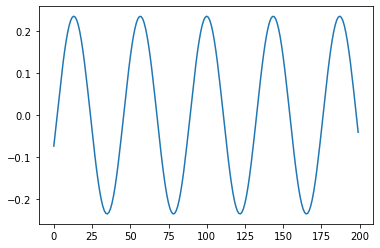

In [30]:
f1 = (14 + np.random.rand())*1e6
a1 = .2351

waveform = single_tone_CW(f1, a1, 625e6)

plt.plot(np.append(waveform[-100:], waveform[:100]))

0.002810285636961396


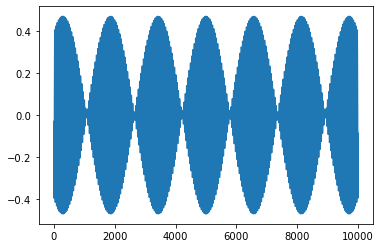

In [40]:
f1 = (14 + np.random.rand())*1e6
a1 = .2351
f2 = (14 + np.random.rand())*1e6
a2 = .2351

waveform = two_tone_CW(f1, a1, f2, a2, 625e6)

plt.plot(np.append(waveform[-5000:], waveform[:5000]))